#############Training with batch size: 64, learning rate: 0.001#############


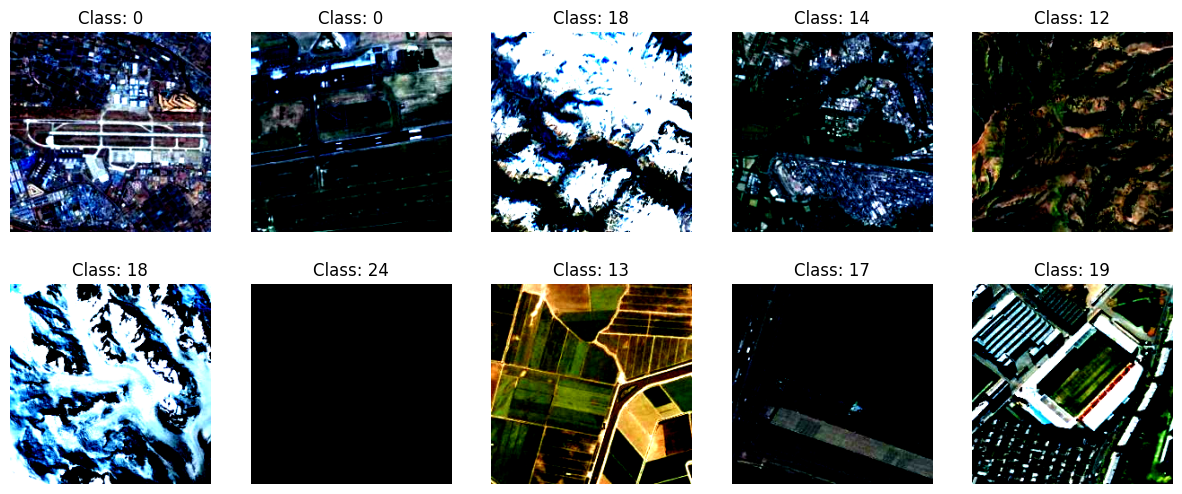

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 2.0233186023930707, Accuracy: 37.97%, Validation Loss: 2.2490200086073444, Validation Accuracy: 39.71%, Running time: 243.25336575508118
Epoch 2, Loss: 1.5382358382145565, Accuracy: 52.23%, Validation Loss: 1.4145332899960605, Validation Accuracy: 55.94%, Running time: 102.79142999649048
Epoch 3, Loss: 1.3511690758168697, Accuracy: 57.52%, Validation Loss: 1.490426434170116, Validation Accuracy: 55.00%, Running time: 106.25475454330444
Epoch 4, Loss: 1.1655010742445786, Accuracy: 63.29%, Validation Loss: 1.3012939138845965, Validation Accuracy: 60.20%, Running time: 101.54732418060303
Epoch 5, Loss: 1.0297780359784763, Accuracy: 67.76%, Validation Loss: 1.2662393634969538, Validation Accuracy: 62.29%, Running time: 99.01664209365845
Epoch 6, Loss: 0.9258378826392194, Accuracy: 70.42%, Validation Loss: 1.38968745470047, Validation Accuracy: 60.66%, Running time: 105.46204924583435
Epoch 7, Loss: 0.8269594133210679, Accuracy: 73.83%, Validation Loss: 0.9503297524018721, Va

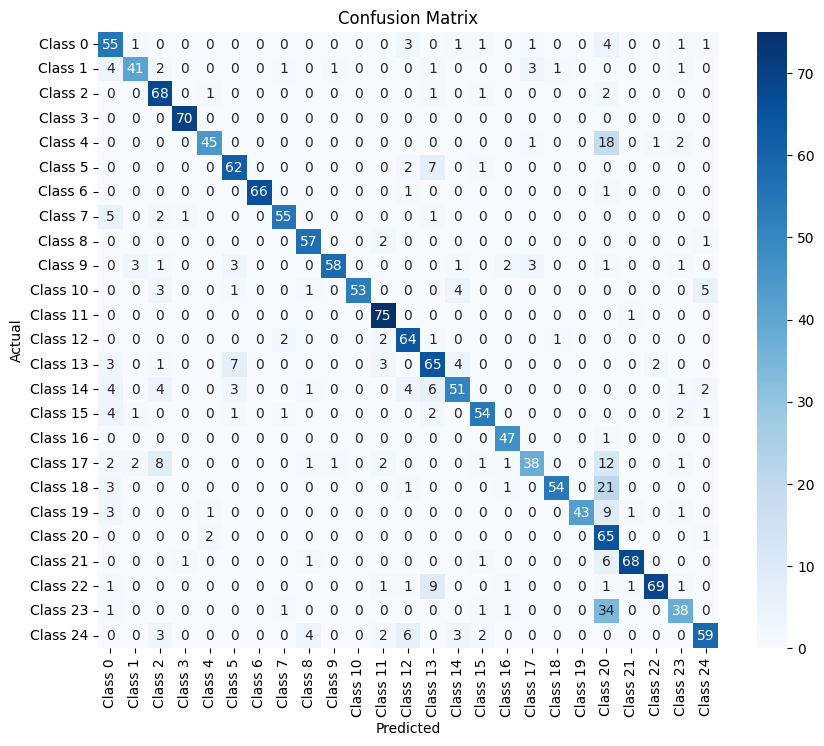

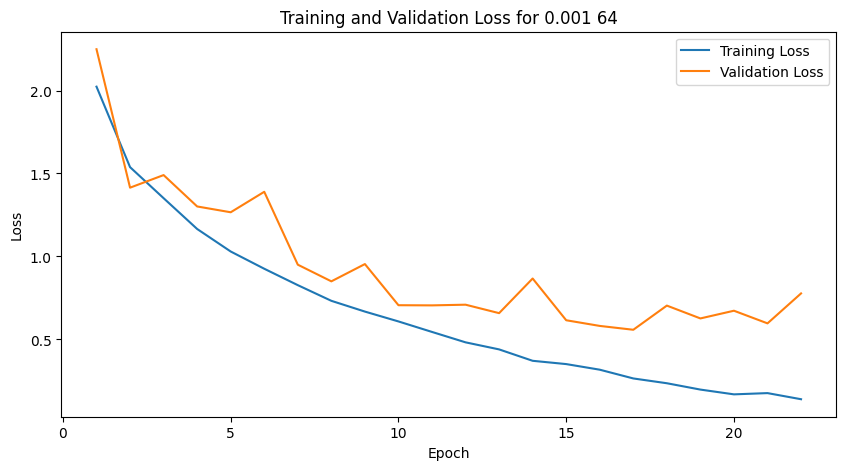

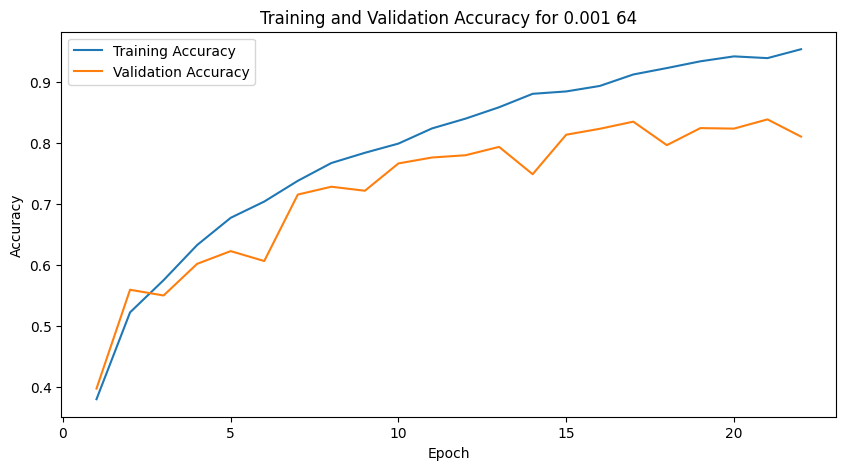

In [5]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset
dataset = torchvision.datasets.ImageFolder(root=r'/kaggle/input/NWPU-RESISC45', transform=data_transforms)

# Split dataset
train_size = int(0.7 * len(dataset)) 
valid_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))  
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Define batch sizes and learning rates
batch_sizes = [64]
learning_rates = [0.001]
num_epochs = 40

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        print(f"#############Training with batch size: {batch_size}, learning rate: {learning_rate}#############")
        
        # Generate a random sample of 10 images from the test dataset
        sample_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
        sample_iter = iter(sample_loader)
        sample_images, sample_labels = next(sample_iter)

        # Display the sample images
        plt.figure(figsize=(15, 6))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(sample_images[i].permute(1, 2, 0))  # Transpose the tensor to (H, W, C) for display
            plt.title(f"Class: {sample_labels[i]}")
            plt.axis('off')
        plt.show()
        
        # Create data loaders
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the model
        model = models.resnet18(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 25)

        # Define device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_during_epoch = []
        accuracy_during_epoch = []
        
        patience = 5
        best_valid_loss = float('inf')
        epochs_no_improve = 0
        early_stopping = False

        train_loss_list = []
        train_accuracy_list = []
        valid_loss_list = []
        valid_accuracy_list = []

        for epoch in range(num_epochs):
            start_time = time.time()
            model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for inputs, labels in train_loader:
                # Your existing training code...
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)


            # Validation
            model.eval()
            valid_loss = 0.0
            valid_correct_predictions = 0
            valid_total_predictions = 0

            with torch.no_grad():
                for valid_inputs, valid_labels in valid_loader:
                    valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                    valid_outputs = model(valid_inputs)
                    valid_loss += criterion(valid_outputs, valid_labels).item()

                    _, valid_predicted = torch.max(valid_outputs, 1)
                    valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
                    valid_total_predictions += valid_labels.size(0)


            end_time = time.time()
            elapsed_time = end_time - start_time

            # Calculate metrics
            train_loss = running_loss / len(train_loader)
            train_accuracy = correct_predictions / total_predictions
            valid_loss = valid_loss / len(valid_loader)
            valid_accuracy = valid_correct_predictions / valid_total_predictions

            # Append to lists
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            valid_loss_list.append(valid_loss)
            valid_accuracy_list.append(valid_accuracy)

            print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
                  f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
                  f"Running time: {elapsed_time}")

            # Early stopping logic
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print("Early stopping!")
                    early_stopping = True
                    break

        # After the loop, you can check if early stopping occurred
        if early_stopping:
            print("Training stopped due to early stopping.")
        else:
            print("Training completed all epochs.")

        # Save model weights
        torch.save(model.state_dict(), f'ReSISC45_AlexNet_batch_size_{batch_size}_lr_{learning_rate}.pth')

        # Evaluate the model on test set
        model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        cm = confusion_matrix(y_true, y_pred)

        print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print("Confusion Matrix:")
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(cm))], yticklabels=[f'Class {i}' for i in range(len(cm))])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Determine the minimum length between range and train_loss_list
        min_length = min(len(range(1, num_epochs+1)), len(train_loss_list))

        # Plotting training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, min_length + 1), train_loss_list[:min_length], label='Training Loss')
        plt.plot(range(1, min_length + 1), valid_loss_list[:min_length], label='Validation Loss')
        plt.title('Training and Validation Loss for '+str(learning_rate) + " " + str(batch_size))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Determine the minimum length between range and train_accuracy_list
        min_length_acc = min(len(range(1, num_epochs+1)), len(train_accuracy_list))

        # Plotting training and validation accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, min_length_acc + 1), train_accuracy_list[:min_length_acc], label='Training Accuracy')
        plt.plot(range(1, min_length_acc + 1), valid_accuracy_list[:min_length_acc], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy for '+str(learning_rate) + " " + str(batch_size))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1750 samples in 0.016s...
[t-SNE] Computed neighbors for 1750 samples in 2.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1750
[t-SNE] Computed conditional probabilities for sample 1750 / 1750
[t-SNE] Mean sigma: 56.211677
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.548065
[t-SNE] KL divergence after 2000 iterations: 1.260912


/tmp/ipykernel_34/3377307893.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names))


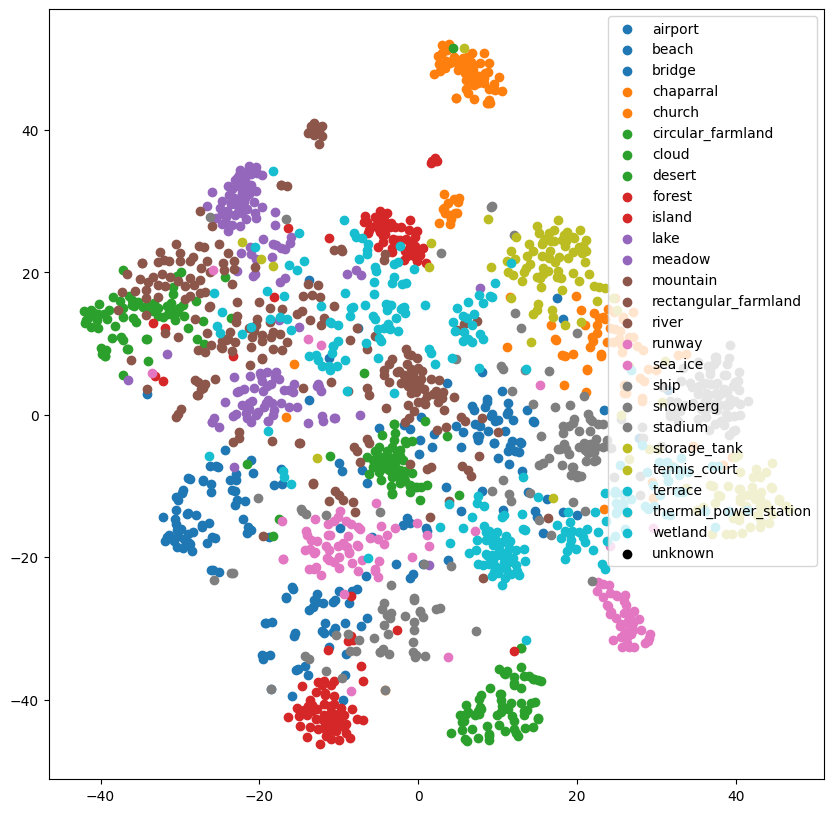

In [7]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.to(device)

model = torch.nn.Sequential(*(list(model.children())[:-1]))

model.eval()

features = []
labels = []
for images, target in test_loader:
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# reshape the features array to have two dimensions
n_samples = features.shape[0]
n_features = np.prod(features.shape[1:])
features = features.reshape((n_samples, n_features))

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names=list(dataset.class_to_idx.keys())

# Create a colormap with enough distinct colors for all classes
cmap = plt.cm.get_cmap('tab10', len(target_names))

u = False

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=[cmap(i)])
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()
